In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
mesh=37
y_val = torch.tensor([134,92])

In [3]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

       CV_f_v  ani_ratio_v    k_FEC    CV_f_a  ani_ratio_a     k_BB
0    0.606444     0.442714  5.53288  0.317814     0.376440  1.35358
1    0.518476     0.304389  6.83032  0.628421     0.237364  1.25791
2    0.641101     0.239081  5.82181  1.020680     0.437033  5.30559
3    0.750099     0.373713  4.49537  0.526532     0.444927  2.07317
4    0.689263     0.388615  2.34609  0.556797     0.477035  2.36587
..        ...          ...      ...       ...          ...      ...
115  0.545148     0.260282  1.41140  0.982380     0.242211  2.02864
116  0.407284     0.272427  1.55631  0.353259     0.340049  1.65963
117  0.796166     0.465371  7.16628  0.539272     0.228129  1.68568
118  0.752534     0.476168  3.40841  0.386740     0.264407  5.40274
119  0.687991     0.318799  6.32706  0.767307     0.234231  4.38626

[120 rows x 6 columns]


In [4]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

        A_TAT     V_TAT
0    296.1940  106.6400
1    170.7960  140.4090
2     63.1401  122.1590
3    148.6480   92.1577
4    133.1920  101.1890
..        ...       ...
115   95.0785  162.8840
116  252.4290  211.9730
117  186.7530   78.9568
118  195.6280   85.1879
119  104.5540  104.2000

[120 rows x 2 columns]


# Emulator

In [5]:
y_all.max()

A_TAT    312.285
V_TAT    224.775
dtype: float64

In [6]:
input_masked = X_all.copy()

In [7]:
y_all

,A_TAT,V_TAT
0,296.1940,106.6400
1,170.7960,140.4090
2,63.1401,122.1590
3,148.6480,92.1577
4,133.1920,101.1890
...,...,...
115,95.0785,162.8840
116,252.4290,211.9730
117,186.7530,78.9568
118,195.6280,85.1879


In [8]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(X_all[0:y_all.shape[0]].values)

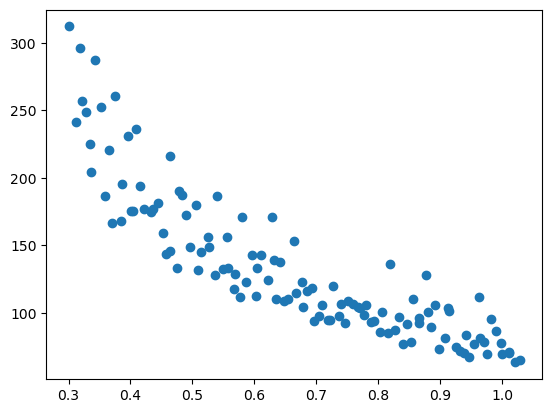

In [9]:
plt.plot(x_train[:,3],y_train[:,0],'o')

In [10]:
y_train

tensor([[296.1940, 106.6400],
        [170.7960, 140.4090],
        [ 63.1401, 122.1590],
        [148.6480,  92.1577],
        [133.1920, 101.1890],
        [132.5730,  91.6085],
        [ 93.5819, 177.4280],
        [106.4450, 133.8390],
        [ 69.9348, 101.1370],
        [ 76.8217, 143.0310],
        [109.8770, 109.3990],
        [176.8380, 143.9360],
        [ 78.2424, 130.4050],
        [ 97.4448, 176.8830],
        [ 93.6578, 122.3940],
        [159.2310,  95.8223],
        [143.1260,  90.5206],
        [103.9100, 111.5330],
        [187.0040, 224.7750],
        [ 96.0024,  89.7075],
        [ 70.5650, 100.6570],
        [ 77.6447, 144.4530],
        [287.4870, 162.1430],
        [156.4700, 157.4960],
        [ 70.4692, 126.2010],
        [248.6590, 130.6360],
        [ 93.2842, 175.0540],
        [ 64.6096, 112.3900],
        [111.5360,  99.6606],
        [110.0210, 159.6500],
        [110.1640, 112.7550],
        [175.0150, 118.9460],
        [ 85.6613,  94.4889],
        [1

In [11]:
x_train.shape

torch.Size([120, 6])

In [12]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1


In [13]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.382351, 0.799717]
[0.201679, 0.499831]
[1.24091, 8.38479]
[0.300623, 1.02851]
[0.200837, 0.497599]
[1.01838, 5.67135]


In [14]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_9647/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [15]:
data1.shape

torch.Size([14336, 6])

In [16]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                      ST   ST_conf
(CV_f_v,)       0.000027  0.000004
(ani_ratio_v,)  0.000062  0.000011
(k_FEC,)        0.000355  0.000084
(CV_f_a,)       0.880538  0.070240
(ani_ratio_a,)  0.041517  0.004702
(k_BB,)         0.092633  0.011082
                      S1   S1_conf
(CV_f_v,)       0.000037  0.000488
(ani_ratio_v,)  0.000249  0.000575
(k_FEC,)        0.000034  0.001444
(CV_f_a,)       0.862256  0.087296
(ani_ratio_a,)  0.035668  0.017747
(k_BB,)         0.082980  0.026816
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                      ST   ST_conf
(CV_f_v,)       0.823726  0.054625
(ani_ratio_v,)  0.151289  0.013781
(k_FEC,)        0.034852  0.004045
(CV_f_a,)       0.000173  0.000036
(ani_ratio_a,)  0.000152  0.000026
(k_BB,)         0.000122  0.000020
                      S1   S1_conf
(CV_f_v,)       0.814916  0.072446
(ani_ratio_v,)  0.144044  0.033301
(k_FEC,)        0.028491  0.016340
(CV_f_a,)      -0.000180  0.001121
(ani_ratio_a,)  0.000262  0.001061
(k_BB,

In [17]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [18]:
x_labels.values.squeeze().tolist()

['CV_f_v', 'ani_ratio_v', 'k_FEC', 'CV_f_a', 'ani_ratio_a', 'k_BB']

In [19]:
y_all.columns.tolist()

['A_TAT', 'V_TAT']

In [20]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

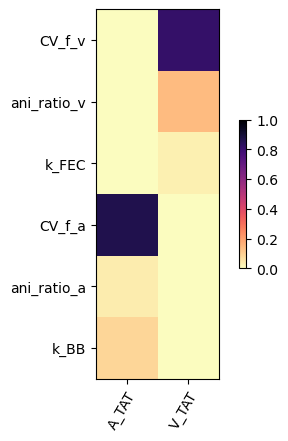

In [21]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

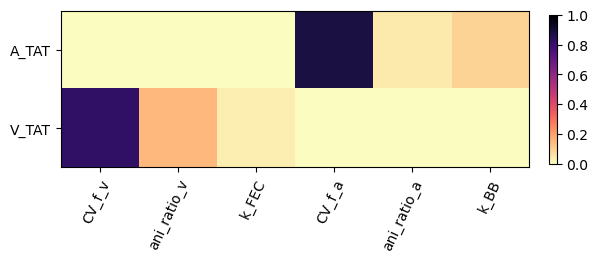

In [22]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [23]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [24]:
boundsMaxMin

[[0.382351, 0.799717],
 [0.201679, 0.499831],
 [1.24091, 8.38479],
 [0.300623, 1.02851],
 [0.200837, 0.497599],
 [1.01838, 5.67135]]

In [25]:
centre[[1,2,4,5,]]

array([0.350755, 4.81285 , 0.349218, 3.344865])

In [26]:
boundsMaxMin=np.array(boundsMaxMin)

In [27]:
down=centre[[1,2,4,5,]]-centre[[1,2,4,5,]]*0.05
up=centre[[1,2,4,5,]]+centre[[1,2,4,5,]]*0.05

In [28]:
boundsMaxMin[[1,2,4,5,],0]=down

In [29]:
boundsMaxMin[[1,2,4,5,],1]=up

In [30]:
boundsMaxMin

array([[0.382351  , 0.799717  ],
       [0.33321725, 0.36829275],
       [4.5722075 , 5.0534925 ],
       [0.300623  , 1.02851   ],
       [0.3317571 , 0.3666789 ],
       [3.17762175, 3.51210825]])

In [31]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [49]:
def log_likelihood(x,emulator,y_val,obs_error):
    x=torch.tensor(x)[None]
    with gpytorch.settings.fast_pred_var(): #This line makes it fast!
        ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],obs_error)).detach().numpy())
    return ll

In [36]:
def log_prob(theta, emulator,y_val,obs_error):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta,emulator, y_val,obs_error)

In [37]:
import emcee

In [38]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
#y_val = torch.tensor([80,134])
obs_error=((y_val*0.05))**2

In [39]:
y_val+2*((y_val*0.05))

tensor([147.4000, 101.2000])

In [40]:
y_val*0.18

tensor([24.1200, 16.5600])

In [41]:
obs_error

tensor([44.8900, 21.1600])

In [42]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val,obs_error])

sampler.run_mcmc(p0, 40000,progress=True)

100%|█████████████████████████████████████| 40000/40000 [07:27<00:00, 89.47it/s]


State([[0.76612343 0.342885   5.02293215 0.53852659 0.35805356 3.44011833]
 [0.76244625 0.34565062 5.00225567 0.5414043  0.33904509 3.51098538]
 [0.78315056 0.34167663 4.91361051 0.57755133 0.35083866 3.23616956]
 [0.73823146 0.33968603 4.80541562 0.53455768 0.3520351  3.37793624]
 [0.77476689 0.36270906 4.93922685 0.57934954 0.34133579 3.31919528]
 [0.77021503 0.34434812 4.82957475 0.59622373 0.34367943 3.34921163]
 [0.75327469 0.3573652  4.6230776  0.55767658 0.36546505 3.38211872]
 [0.76488383 0.36555583 5.01816687 0.52280994 0.36206364 3.49790801]
 [0.77974156 0.338399   4.58128249 0.61145797 0.33291261 3.4680475 ]
 [0.76792262 0.34048603 4.82756519 0.56598426 0.35898327 3.19429733]
 [0.79294161 0.34975468 4.60537512 0.5736219  0.35537752 3.50790365]
 [0.7776901  0.33953346 4.60245599 0.51869343 0.33770425 3.41494575]
 [0.77483995 0.35050908 4.78960176 0.57116647 0.33610633 3.29654407]
 [0.76970759 0.33375329 4.71828394 0.56085853 0.3446915  3.46606253]
 [0.76940454 0.33500532 4.83

In [44]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(36000, 6)


In [45]:
boundsMaxMin

array([[0.382351  , 0.799717  ],
       [0.33321725, 0.36829275],
       [4.5722075 , 5.0534925 ],
       [0.300623  , 1.02851   ],
       [0.3317571 , 0.3666789 ],
       [3.17762175, 3.51210825]])

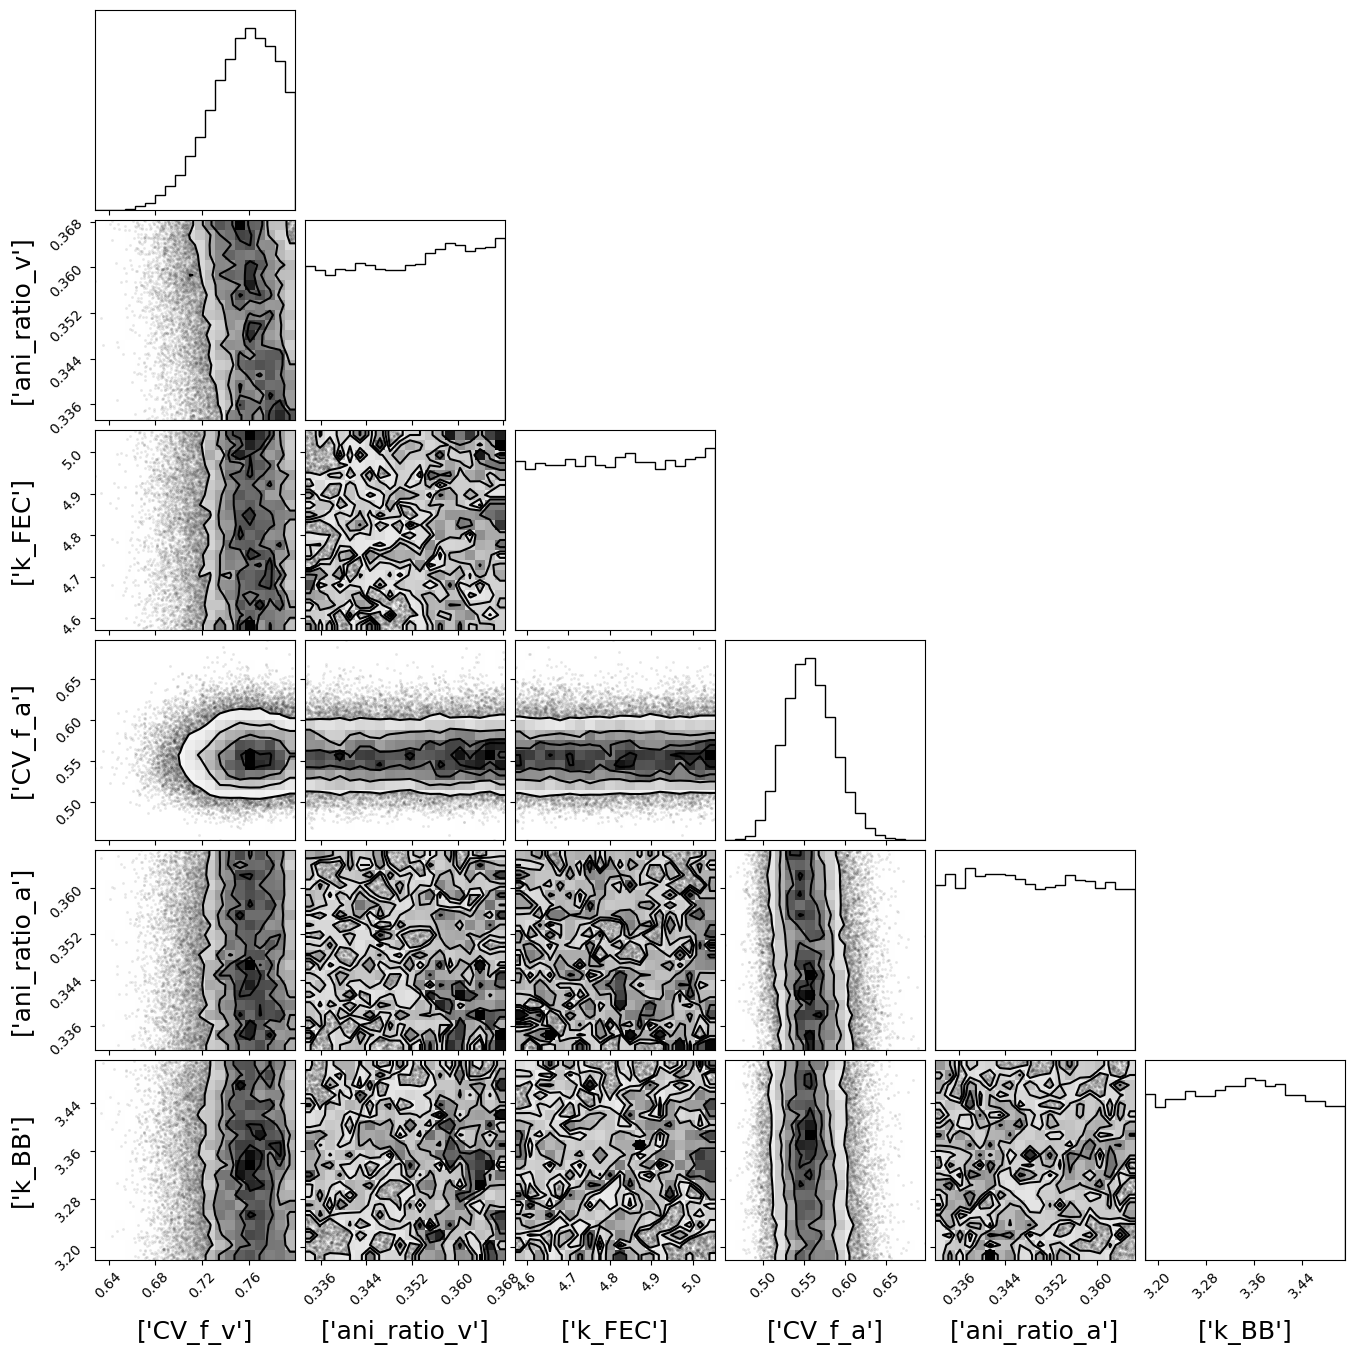

In [46]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

(array([3.0000e+01, 3.8500e+02, 2.5750e+03, 7.5400e+03, 1.1259e+04,
        9.1740e+03, 4.0870e+03, 8.7300e+02, 7.3000e+01, 4.0000e+00]),
 array([106.7566452 , 112.43875885, 118.1208725 , 123.80298615,
        129.48509216, 135.16720581, 140.84931946, 146.53143311,
        152.21354675, 157.8956604 , 163.57777405]),
 <BarContainer object of 10 artists>)

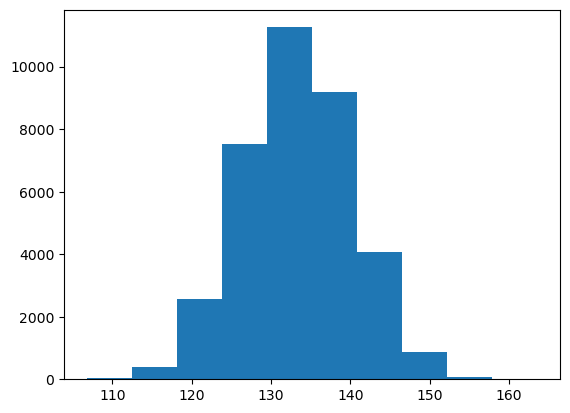

In [47]:
plt.hist(emulator.predict(torch.tensor(flat_samples)).detach().numpy()[:,0])

In [48]:
emulator.predict(torch.tensor(flat_samples)).mean(axis=0)

tensor([133.3087,  93.1542], grad_fn=<MeanBackward1>)

In [46]:
emulator.predict(torch.tensor(flat_samples)).std(axis=0)

tensor([6.8136, 3.7360], grad_fn=<StdBackward0>)

In [47]:
y_val*0.05

tensor([6.7000, 4.6000])

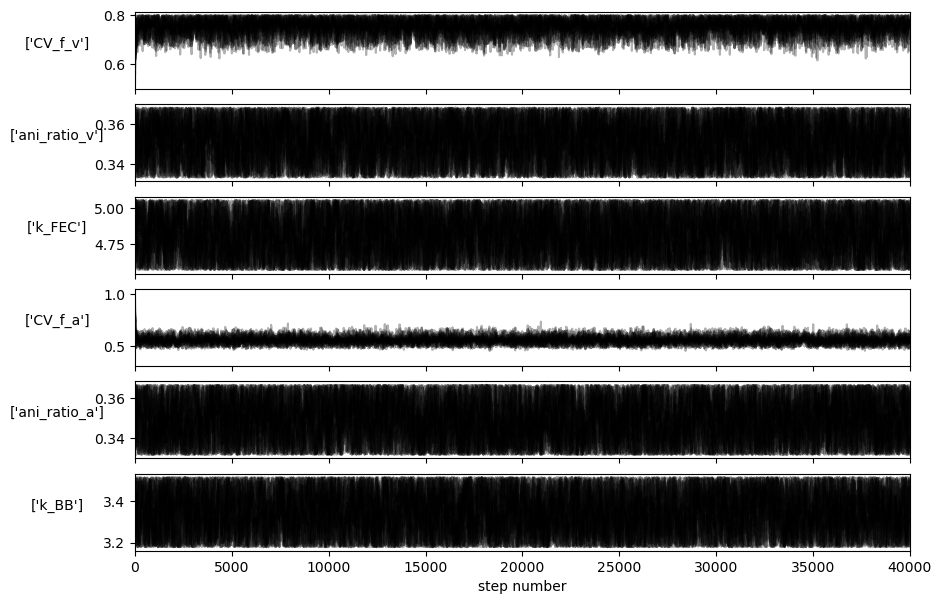

In [50]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [51]:
y_all.max()

A_TAT    312.285
V_TAT    224.775
dtype: float64

In [52]:
y_all.min()

A_TAT    63.1401
V_TAT    78.9568
dtype: float64

In [53]:
flat_samples.mean(axis=0)-flat_samples.std(axis=0)

array([0.72658979, 0.34119638, 4.67538304, 0.52801533, 0.33898792,
       3.24958579])

In [54]:
flat_samples.mean(axis=0)+flat_samples.std(axis=0)

array([0.78209939, 0.3615492 , 4.95392491, 0.58739269, 0.35907956,
       3.43915135])

In [55]:
boundsMaxMin.T

array([[0.382351  , 0.33321725, 4.5722075 , 0.300623  , 0.3317571 ,
        3.17762175],
       [0.799717  , 0.36829275, 5.0534925 , 1.02851   , 0.3666789 ,
        3.51210825]])

In [56]:
emulator.predict(torch.tensor(flat_samples.mean(axis=0))[None])

tensor([[132.8639,  93.1040]], grad_fn=<PermuteBackward0>)